<h1 style="text-align:center;font-size:30px;" > Image Segementation on Indian Driving Dataset </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>In ​computer vision​, Image segmentation is the process of partitioning  a ​digital image​ into multiple segments. The goal of segmentation is to  simplify and/or change the representation of an image into something  that is more meaningful and easier to analyze.</p>
<p> Indian Driving Dataset is ​a novel dataset for road scene understanding  in unstructured environments. Unstructured environments usually  corresponds to well-delineated infrastructure such as lanes, a small  number of well-defined categories for traffic participants, low variation  in object or background appearance and strong adherence to traffic  rules.  </p>
<p></p>
<p></p>

<h2> 1.2 Sources/Useful Links</h2>


- Source : https://idd.insaan.iiit.ac.in/

<h2> 2. Data </h2>

<h3> 2.1.1 Data Overview </h3>


- Indian Driving Dataset ​consists of 10,000 images, finely annotated with  34 classes collected from 182 drive sequences on Indian roads.
- The dataset consists of images obtained from a front facing camera  attached to a car. The car was driven around Hyderabad, Bangalore  cities and their outskirts.  
- This case study would be implemented on IDD Lite dataset which  contains 7 classes compared to 30 in IDD 
- The 7 classes in IDD Lite dataset are :  
● drivable - 0  
● non-drivable - 1  
● living-thing - 2  
● 2-Wheeler, autorickshaw, large-vehicle - 3  
● barrier, structures - 4  
● construction - 5  
● vegetation , sky -6 
 

<h3> 2.1.2 Performance Metric </h3>

The performance metric would be mIoU - Mean Intersection Over  Union also known as Jaccard Index. The mean IoU of the image is  calculated by taking the IoU of each class and averaging them. 


![iou.PNG](attachment:iou.PNG)

<h1>3.  Data Analysis </h1>

In [1]:
import cv2, os, random
import numpy as np
import shutil 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,concatenate,Input,LSTM, Reshape,Permute
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization


from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import he_normal
from time import time
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K


## Data preparation

In [0]:
os. listdir('idd20k_lite')

['gtFine', 'leftImg8bit']

In [0]:
print(os. listdir('idd20k_lite/gtFine'))
print(os. listdir('idd20k_lite/leftImg8bit'))

['train', 'val']
['train', 'val', 'test']


In [0]:
print(os. listdir('idd20k_lite/gtFine/train'))


['175', '528', '575', '203', '493', '473', '267', '448', '95', '547', '280', '173', '371', '263', '409', '143', '30', '1', '160', '277', '32', '498', '437', '237', '137', '146', '116', '539', '560', '299', '428', '151', '177', '80', '29', '377', '477', '5', '490', '57', '168', '11', '76', '442', '65', '441', '93', '265', '406', '339', '446', '452', '438', '548', '331', '293', '34', '376', '522', '303', '578', '476', '258', '126', '460', '532', '322', '100', '91', '351', '115', '207', '321', '544', '108', '431', '373', '491', '432', '306', '556', '433', '163', '174', '282', '235', '489', '216', '478', '561', '411', '162', '340', '520', '60', '87', '429', '9', '482', '508', '98', '382', '252', '225', '513', '302', '266', '453', '462', '63', '413', '512', '70', '301', '135', '457', '36', '220', '247', '25', '81', '273', '502', '102', '529', '419', '157', '138', '573', '421', '470', '464', '77', '164', '7', '204', '68', '475', '206', '145', '26', '336', '56', '503', '201', '59', '78', '84'

In [0]:
print(os. listdir('idd20k_lite/gtFine/train/0'))
print(os. listdir('idd20k_lite/gtFine/train/1'))
print(os. listdir('idd20k_lite/gtFine/train/10'))


['024541_inst_label.png', '024703_inst_label.png', '024703_label.png', '024541_label.png']
['502201_label.png', '662706_label.png', '725984_label.png', '820938_inst_label.png', '502201_inst_label.png', '662706_inst_label.png', '340676_inst_label.png', '725984_inst_label.png', '092468_inst_label.png', '601536_label.png', '820938_label.png', '340676_label.png', '092468_label.png', '601536_inst_label.png']
['092196_label.png', '092196_inst_label.png']


In [0]:
print(os. listdir('idd20k_lite/leftImg8bit/train/0'))
print(os. listdir('idd20k_lite/leftImg8bit/train/1'))
print(os. listdir('idd20k_lite/leftImg8bit/train/10'))

['024541_image.jpg', '024703_image.jpg']
['601536_image.jpg', '502201_image.jpg', '820938_image.jpg', '662706_image.jpg', '092468_image.jpg', '340676_image.jpg', '725984_image.jpg']
['092196_image.jpg']


<li> From the folder structure, we can see that the images are present in the path 'idd20k_lite/leftImg8bit/train/0' where the final folder varies
<li> From the folder structure, we can see that the labels are present in the path 'idd20k_lite/gtFine/train/0' where the final folder varies

### Grouping all images into a single folder i.e., train,val

In [0]:
data = 'idd20k_lite/'

img_train = data + 'leftImg8bit/train/'
seg_train = data + 'gtFine/train/'

img_val = data + 'leftImg8bit/val/'
seg_val = data + 'gtFine/val/'

img_test = data + 'leftImg8bit/test/'


In [0]:
img_train_files = sorted(os.listdir(img_train))
seg_train_files = sorted(os.listdir(seg_train))
img_val_files = sorted(os.listdir(img_val))
seg_val_files = sorted(os.listdir(seg_val))
img_test_files = sorted(os.listdir(img_test))


In [0]:
# train images
path1='idd20k_lite1/leftImg8bit/train/'
for i in img_train_files:
    subpath = img_train + i+'/'
    for j in os.listdir(subpath):
        source=subpath+j
        destination=path1+j
        dest = shutil.copy(source, destination) 

# val images
path1='idd20k_lite1/leftImg8bit/val/'
for i in img_val_files:
    subpath = img_val + i+'/'
    for j in os.listdir(subpath):
        source=subpath+j
        destination=path1+j
        dest = shutil.copy(source, destination) 

# test images
path1='idd20k_lite1/leftImg8bit/test/'
for i in img_test_files:
    subpath = img_test + i+'/'
    for j in os.listdir(subpath):
        source=subpath+j
        destination=path1+j
        dest = shutil.copy(source, destination) 

# train labels
path1='idd20k_lite1/gtFine/train/'
for i in seg_train_files:
    subpath = seg_train + i+'/'
    for j in os.listdir(subpath):
        source=subpath+j
        destination=path1+j
        dest = shutil.copy(source, destination)
    
# val labels
path1='idd20k_lite1/gtFine/val/'
for i in seg_val_files:
    subpath = seg_val + i+'/'
    for j in os.listdir(subpath):
        source=subpath+j
        destination=path1+j
        dest = shutil.copy(source, destination) 

<h4><font color="red">Data Prepearation completed

## Loading the final data

In [3]:
data = 'idd20k_lite1/'

img_train = data + 'leftImg8bit/train/'
seg_train = data + 'gtFine/train/'

img_test = data + 'leftImg8bit/val/'
seg_test = data + 'gtFine/val/'


In [4]:
img_train_files = sorted(os.listdir(img_train))
seg_train_files = sorted(os.listdir(seg_train))
img_test_files = sorted(os.listdir(img_test))
seg_test_files = sorted(os.listdir(seg_test))

In [5]:
train_img = os.listdir(img_train)
train_img.sort()
train_seg = os.listdir(seg_train)
train_seg.sort()

test_img = os.listdir(img_test)
test_img.sort()
test_seg = os.listdir(seg_test)
test_seg.sort()


In [0]:
train_seg[:6]

['0000002_inst_label.png',
 '0000002_label.png',
 '0000097_inst_label.png',
 '0000097_label.png',
 '0000192_inst_label.png',
 '0000192_label.png']

In [0]:
test_seg[:6]

['0000000_inst_label.png',
 '0000000_label.png',
 '000065_inst_label.png',
 '000065_label.png',
 '0001080_inst_label.png',
 '0001080_label.png']

<li> The label images are of 2 types,semantic segementation and instance segmentation

In [6]:
# separating semantic and instance segmentation labels
train_seg_label=[]
train_inst_seg=[]
for i in range(1,len(train_seg)):
    if(i%2 !=0):
        train_seg_label.append(train_seg[i])
    else:
        train_inst_seg.append(train_seg[i])

test_seg_label=[]
test_inst_seg=[]
for i in range(len(test_seg)):
    if(i%2 !=0):
        test_seg_label.append(test_seg[i])
    else:
        test_inst_seg.append(test_seg[i])


In [7]:
print(train_img[:5])
print(train_seg_label[:5])
print(test_img[:5])
print(test_seg_label[:5])

['0000002_image.jpg', '0000097_image.jpg', '0000192_image.jpg', '0000215_image.jpg', '0000247_image.jpg']
['0000002_label.png', '0000097_label.png', '0000192_label.png', '0000215_label.png', '0000247_label.png']
['0000000_image.jpg', '000065_image.jpg', '0001080_image.jpg', '000190_image.jpg', '0001923_image.jpg']
['0000000_label.png', '000065_label.png', '0001080_label.png', '000190_label.png', '0001923_label.png']


### Number of images and size of image

In [8]:
for i in range(len(train_img)):
    first_img = cv2.imread('idd20k_lite1/leftImg8bit/train/'+train_img[0])
    img = cv2.imread('idd20k_lite1/leftImg8bit/train/'+train_img[i])
    if(first_img.shape == img.shape):
        if(i==len(train_img)-1):
            print('Number of train Images =',len(train_img))
            print('All Train Images have same shape')
            print('Shape of all Train images =',img.shape)
        continue
    else:
        print(train_img[i]+' has shape :',img.shape)
print('='*80)

for i in range(len(train_seg_label)):
    first_img = cv2.imread('idd20k_lite1/gtFine/train/'+train_seg_label[0])
    img = cv2.imread('idd20k_lite1/gtFine/train/'+train_seg_label[i])
    if(first_img.shape == img.shape):
        if(i==len(train_img)-1):
            print('Number of train labels =',len(train_seg_label))
            print('All Train Labels have same shape')
            print('Shape of all Train Labels =',img.shape)
        continue
    else:
        print(train_seg_label[i]+' has shape :',img.shape)
print('='*80)

for i in range(len(test_img)):
    first_img = cv2.imread('idd20k_lite1/leftImg8bit/val/'+test_img[0])
    img = cv2.imread('idd20k_lite1/leftImg8bit/val/'+test_img[i])
    if(first_img.shape == img.shape):
        if(i==len(test_img)-1):
            print('Number of Test Images =',len(test_img))
            print('All Test Images have same shape')
            print('Shape of all Test images =',img.shape)
        continue
    else:
        print(test_img[i]+' has shape :',img.shape)
print('='*80)



Number of train Images = 1380
All Train Images have same shape
Shape of all Train images = (227, 320, 3)
Number of train labels = 1380
All Train Labels have same shape
Shape of all Train Labels = (227, 320, 3)
Number of Test Images = 204
All Test Images have same shape
Shape of all Test images = (227, 320, 3)


### Observations :-
<li> All images and labels in train, validation and test have same size which is (227,320,3)
<li> All images and labels have 3 channels, i.e., all are of RGB format

## Preparing final train and val datasets :-

In [9]:
from sklearn.model_selection import train_test_split

X_tr,X_cr, y_tr, y_cr = train_test_split(train_img, train_seg_label, test_size=0.25, random_state=15)


In [10]:
print(X_tr[:5])
print(y_tr[:5])
print(X_cr[:5])
print(y_cr[:5])

['0043118_image.jpg', '881557_image.jpg', '862328_image.jpg', '960225_image.jpg', 'frame0731_image.jpg']
['0043118_label.png', '881557_label.png', '862328_label.png', '960225_label.png', 'frame0731_label.png']
['355117_image.jpg', 'frame7284_image.jpg', '978273_image.jpg', 'frame7149_image.jpg', '010441_image.jpg']
['355117_label.png', 'frame7284_label.png', '978273_label.png', 'frame7149_label.png', '010441_label.png']


In [245]:
# Resizing image height to 256 beacuse to send as image as inout to uNET model the height and width of the image should
# multiples of 32
height=256
width=320
n_classes=7
def prepare_image_data(path,data):
    src=path+data
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img = np.float32(img)  / 255        #normalization
    return img

# https://github.com/advaitsave/Multiclass-Semantic-Segmentation-CamVid/blob/master/Multiclass%20Semantic%20Segmentation%20using%20U-Net.ipynb
def prepare_label_data(path,data):
    label = np.zeros((height, width, n_classes))
    src=path+data
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img1=img[:,:,0]
    for i in range(n_classes):
        label[:,:,i] = (img1==i).astype(int)
    return label
    

In [246]:
X_train, y_train, X_val, y_val, X_test = [], [], [], [], []


In [247]:
for i in range(len(X_tr)):
    X_train.append(prepare_image_data(img_train,X_tr[i]))

for i in range(len(y_tr)):
    y_train.append(prepare_label_data(seg_train,y_tr[i]))

for i in range(len(X_cr)):
    X_val.append(prepare_image_data(img_train,X_cr[i]))

for i in range(len(y_cr)):
    y_val.append(prepare_label_data(seg_train,y_cr[i]))

In [248]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val=np.array(y_val)

In [249]:
print('Train Data : ')
print('Images-',X_train.shape)
print('Labels-',y_train.shape)
print('='*40)
print('Validation Data : ')
print('Images-',X_val.shape)
print('Labels-',y_val.shape)
print('='*40)

Train Data : 
Images- (1035, 256, 320, 3)
Labels- (1035, 256, 320, 7)
Validation Data : 
Images- (345, 256, 320, 3)
Labels- (345, 256, 320, 7)


In [22]:
x=X_train[0]
y=y_train[0]
print(x.shape)
print(y.shape)

(256, 320, 3)
(256, 320, 7)


In [ ]:
def prepare_label_data(path,data):
    label = np.zeros((height, width, n_classes))
    src=path+data
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img1=img[:,:,0]
    for i in range(n_classes):
        label[:,:,i] = (img1==i).astype(int)
    return label

In [167]:
def channel7_to_1(data):
    img_1=np.zeros((height, width, 1))
    for i in range(7):
        i1=data[:,:,i]
        for j in range(len(i1)):
            for k in range(len(i1[0])):
                if(i1[j][k]==1):
                    img_1[j][k]=i
    return img_1

In [168]:
kk=channel7_to_1(y)
kk.shape

(256, 320, 1)

In [18]:
i1=y[:,:,0]
print(i1.shape)
for i in range(len(i1)):
    for j in range(len(i1[0])):
        if(i1[i][j]!=0):
            

(256, 320)


In [91]:
img_1=np.zeros((height, width, 1))
#src=path+data
#img_7 = cv2.imread(y)
for i in range(7):
    i1=y[:,:,i]
    for j in range(len(i1)):
        for k in range(len(i1[0])):
            if(i1[j][k]==1):
                img_1[j][k]=i

In [92]:
img_1.shape

(256, 320, 1)

In [169]:
img_1=kk[:,:,0]
img_1.shape

(256, 320)

In [28]:
y_tr[0]

'0043118_label.png'

In [170]:
qq=cv2.imread(seg_train+y_tr[0])
qq=cv2.resize(qq,(width,height))
qq.shape

(256, 320, 3)

In [171]:
qq0=qq[:,:,0]
qq0.shape

(256, 320)

In [172]:
def VisualizeSegmentationImages(img_seg):    
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if(img_seg[i][j]!=0 or img_seg[i][j]!=255):
                img_seg[i][j] *=40
    img2=np.zeros((256, 320, 1))
    img2[:,:,0] = img_seg
    return img2


In [173]:
h1=VisualizeSegmentationImages(qq0)
h2=VisualizeSegmentationImages(img_1)

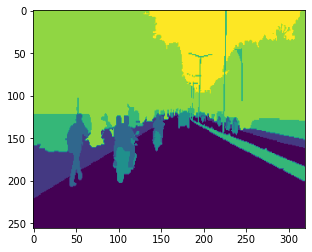

In [174]:
plt.imshow(h1[:,:,0])

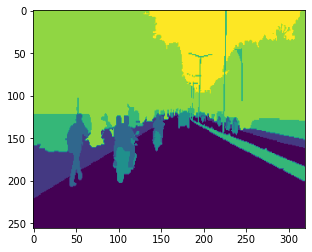

In [175]:
plt.imshow(h2[:,:,0])

### Performance Metric :
<li>The performance metric would be mIoU - Mean Intersection Over  Union also known as Jaccard Index. The mean IoU of the image is  calculated by taking the IoU of each class and averaging them. 

In [0]:
%load_ext tensorboard

In [0]:
tf.keras.backend.clear_session()


In [0]:
import random as rn
np.random.seed(42)
tf.random.set_seed(32)
rn.seed(12)

In [142]:
def IoU(y_val, y_pred):
    class_iou = []
    n_classes = 7
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU

In [143]:
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : IoU( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

<h1><font color='red'>VGG16(encoder)+Unet(decoder)

In [135]:
from tensorflow.keras.applications.vgg16 import VGG16
encoder_vgg16 = VGG16(input_shape =  (256, 320,3), include_top = False, weights = 'imagenet')
encoder_vgg16.trainable = False


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 8s 0us/step


In [136]:
encoder_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 80, 128)       0     

In [0]:
for l in encoder_vgg16.layers:
    l.trainable = False

In [137]:
conv1 = encoder_vgg16.get_layer("block1_conv2").output
conv2 = encoder_vgg16.get_layer("block2_conv2").output
conv3 = encoder_vgg16.get_layer("block3_conv3").output
conv4 = encoder_vgg16.get_layer("block4_conv3").output

def vgg_unet1():

    up5 = Conv2D(256, 2, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.glorot_normal(seed=58))(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3,up5], axis = 3)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.glorot_normal(seed=58))(merge5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.glorot_normal(seed=58))(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = keras.initializers.glorot_normal(seed=58))(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.glorot_normal(seed=58))(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.glorot_normal(seed=58))(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = keras.initializers.glorot_normal(seed=58))(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.glorot_normal(seed=58))(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.glorot_normal(seed=58))(conv7)

    conv8 = Conv2D(7, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.glorot_normal(seed=58))(conv7)
    out = (Activation('softmax'))(conv8)
  
    model = Model(encoder_vgg16.input,out)
    
    return model


## Model  : VGG16(encoder)+Unet(decoder) - [with image augmentation]

In [0]:
%load_ext tensorboard

In [138]:
conv1 = encoder_vgg16.get_layer("block1_conv2").output
conv2 = encoder_vgg16.get_layer("block2_conv2").output
conv3 = encoder_vgg16.get_layer("block3_conv3").output
conv4 = encoder_vgg16.get_layer("block4_conv3").output

def vgg_unet2():

    up5 = Conv2D(256, 2, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.he_normal(seed=58))(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3,up5], axis = 3)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.he_normal(seed=58))(merge5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.he_normal(seed=58))(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = keras.initializers.he_normal(seed=58))(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.he_normal(seed=58))(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.he_normal(seed=58))(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = keras.initializers.he_normal(seed=58))(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.he_normal(seed=58))(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.he_normal(seed=58))(conv7)

    conv8 = Conv2D(7, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = keras.initializers.he_normal(seed=58))(conv7)
    out = (Activation('softmax'))(conv8)
  
    model = Model(encoder_vgg16.input,out)
    
    return model


In [139]:
vgg_unet_model2 = vgg_unet2()
vgg_unet_model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 160, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [0]:
log_dir_2 = os.path.join('vgg_unet_model2') 
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir_2) 

In [0]:
vgg_unet_model2.compile(optimizer = Adam(0.0001), loss = 'categorical_crossentropy',metrics = [miou])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

#Data Augmentation
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.15, height_shift_range=0.15)
# prepare iterator
trainX_gen = datagen.flow(X_train,seed=123)
trainY_gen = datagen.flow(y_train,seed=123)



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1035, 256, 320, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
train_generator = zip(trainX_gen, trainY_gen)

In [0]:
x=X_train.shape[0]//15
x

69

In [0]:
history2=vgg_unet_model2.fit(train_generator,steps_per_epoch=x,epochs=65,verbose=1,
                                  validation_data=(X_val, y_val),callbacks=[tensorboard_callback2])

Epoch 1/65
69/69 [==============================] - 137s 2s/step - loss: 1.5308 - miou: 0.1673 - val_loss: 0.9904 - val_miou: 0.2897
Epoch 2/65
69/69 [==============================] - 135s 2s/step - loss: 0.9339 - miou: 0.2950 - val_loss: 0.8465 - val_miou: 0.3123
Epoch 3/65
69/69 [==============================] - 134s 2s/step - loss: 0.8407 - miou: 0.3232 - val_loss: 0.7646 - val_miou: 0.3432
Epoch 4/65
69/69 [==============================] - 133s 2s/step - loss: 0.7715 - miou: 0.3456 - val_loss: 0.7306 - val_miou: 0.3463
Epoch 5/65
69/69 [==============================] - 133s 2s/step - loss: 0.7480 - miou: 0.3510 - val_loss: 0.6909 - val_miou: 0.3582
Epoch 6/65
69/69 [==============================] - 134s 2s/step - loss: 0.7208 - miou: 0.3594 - val_loss: 0.6728 - val_miou: 0.3634
Epoch 7/65
69/69 [==============================] - 133s 2s/step - loss: 0.6963 - miou: 0.3633 - val_loss: 0.6606 - val_miou: 0.3749
Epoch 8/65
69/69 [==============================] - 134s 2s/step - lo

In [0]:
%tensorboard --logdir vgg_unet_model2

Reusing TensorBoard on port 6006 (pid 11950), started 0:00:52 ago. (Use '!kill 11950' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
y_pred = vgg_unet_model2.predict(X_val)
print('MIoU for VGG16_UNet model with Image augmentation is :',IoU(y_val, y_pred))

MIoU for VGG16_UNet model with Image augmentation is : 0.5732448016046646


In [140]:
vgg_unet_model2.load_weights('vgg_unet_model2_weights.h5')     

In [193]:
y_pred = vgg_unet_model2.predict(X_val)
print('MIoU for VGG16_UNet model with Image augmentation is :',IoU(y_val, y_pred))

MIoU for VGG16_UNet model with Image augmentation is : 0.5729828646142275


### Tensorboard plots

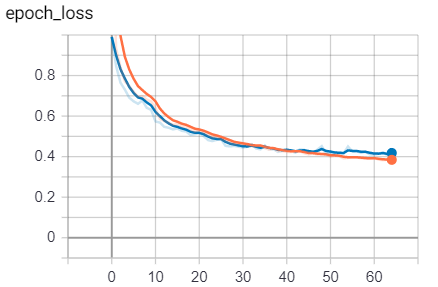

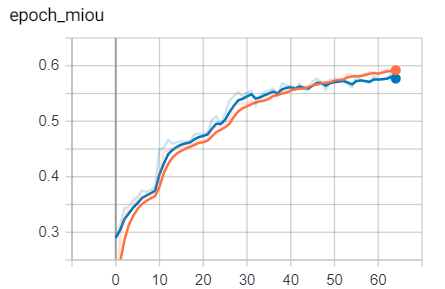

In [214]:
print(y_pred.shape)

(345, 256, 320, 7)


In [216]:
y_predi = np.argmax(y_pred, axis=3)
y_truei = np.argmax(y_val, axis=3)
print(y_predi.shape)
print(y_truei.shape)

(345, 256, 320)
(345, 256, 320)


In [218]:
def VisualizeSegmentationImages(img_seg):    
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if(img_seg[i][j]!=0 or img_seg[i][j]!=255):
                img_seg[i][j] *=40
    img2=np.zeros((256, 320, 1))
    img2[:,:,0] = img_seg
    return img2


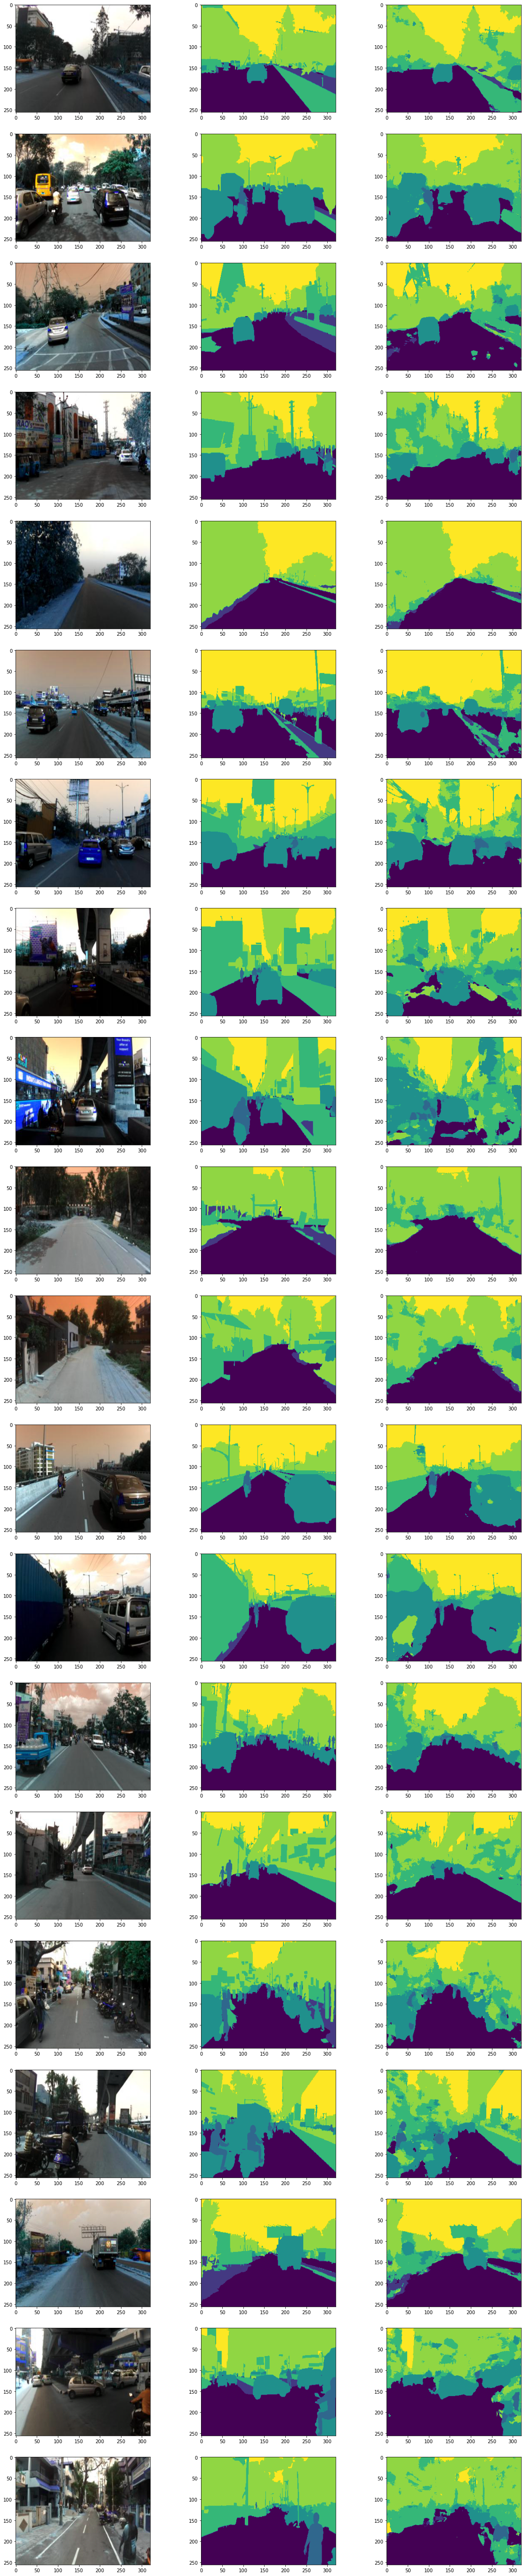

In [299]:
plt.figure(figsize=(20,100))
i=1
for _ in range(0,20):
    j=random.randint(0,345)
    plt.subplot(20,3,i)
    plt.imshow(X_val[j])
    
    plt.subplot(20,3,i+1)
    plt.imshow(VisualizeSegmentationImages(y_truei[j])[:,:,0])
    
    plt.subplot(20,3,i+2)
    plt.imshow(VisualizeSegmentationImages(y_predi[j])[:,:,0])
    i+=3

<h2> Analyzing the error in images :</h2>
<li>From the predictions it can be analyzed that the model is confused when there are vehicles or persons very close to each other